## If all that makes sense, then we can easily use the same process to create a high-pass filter
* If you low-pass the data, then high frequencies are discarded and only low-frequencies remain
* That means that the high frequency info in your data is equal to (original_signal - lp_filtered_signal)
* So if you have symetric filters, like our sinc functions, you can just invert it and you've got a high-pass filter that does the opposite of our low pass filter 
* Conceptually, a high-pass filter looks like our 'brick wall' low pass filter (see first part of last tutorial), except that it is zeros for low-frequencies and non-zero for high-frequencies

## Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy import signal

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

## Simulated timeseries

In [2]:
# our frequencies to work with
frequs = [5, 12, 17, 45, 58]
# first lets set up a more interesting signal with some higher frequencies
sr = 512                        # samp rate in Hz
tmax = 4                        # duration of signal, in s
dt = 1/sr                       # time step, reciprocal of the sr
t = np.arange(0,tmax,dt)        # time axis

# add up a bunch of sin waves at each of our desired frequencies
sig = np.zeros(len(t))
for f in np.arange(len(frequs)):
    sig = sig + np.sin(2*np.pi*frequs[f]*t)

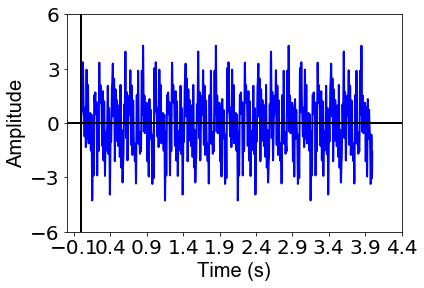

In [3]:
# Plot
plt.plot(t, sig, 'b-', linewidth = 2)    # specify x,y data...in this case time and amplitude of sin

# put some labels on the axes
plt.xlabel('Time (s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)

# set the tick marks
plt.xticks(np.arange(-.1,tmax+.5,.5), color='k', size=20)
plt.yticks(np.linspace(-6,6,5), color='k', size=20)

# add some nice vertical/horizontal lines 
plt.axvline(0, color = 'k', linewidth = 2)
plt.axhline(0, color = 'k', linewidth = 2)

# show it
plt.show()

## Make our filter - just like with the low pass filter, but invert the filter
* Since we're using this a lot, lets make a function out of it...will come in handy for band pass and stop band filters too

In [27]:
%%writefile define_sinc_filter
def define_sinc_filter(fc, b, window, type_filt):
    """Define a lp or a hp filter

    Args:
        fc (float): cutoff frequency, as a fraction of sampling rate
        b (float): transition band, as a fraction of sampling rate
        window (str): window sinc filter, options 'none', 'blackman', 'hanning'
        type_filt (str): low pass or high pass filter, options 'lp', 'hp'

    Returns:
        n (int array): span of filter
        sinc (float array): cinc filter in time domain

    """
    
    # NOTE: do some arg checks here if you want a more robust function
    
    
    # more on this below, but now need to make sure that ceil(4/b) is odd
    N = int(np.ceil((4 / b)))

    # make sure filter length is odd
    if not N % 2: N += 1  

    # generate span over which to eval sinc function    
    n = np.arange(N)

    # Compute the filter
    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))

    # generate our window
    if window == 'blackman':
        win = np.blackman(N)
        
    elif window == 'hanning':
        win = np.hanning(N)
        
    elif window == 'none':
        # if 'none' then just an array of ones so that the values in the sinc aren't modified
        win = np.ones(N)
        
    else:
        print('Unknown window type')
        
    # apply the windowing function 
    sinc_func = sinc_func * win

    # Normalize to have an area of 1 (unit area)
    sinc_func = sinc_func / np.sum(sinc_func)

    # check filter type...if lp then do nothing, else if hp invert, else return msg
    if type_filt == 'lp':
        return n, sinc_func
    
    elif type_filt == 'hp':
        # invert
        sinc_func = -1*sinc_func
        # add 1 to middle of the inverted function 
        sinc_func[int((N-1)/2)]+=1
        return n, sinc_func
    
    else:    
        print('error - unknown filter type')
        

Writing define_sinc_filter


## Call our function to make a hp filter.

In [28]:
fc=0.1
b=0.1
win = 'blackman'
type_filt = 'hp'

# make our function call to generate a hp filter
n, sinc_func = define_sinc_filter(fc=fc, b=b, window=win, type_filt=type_filt)

## Plot our high pass filter

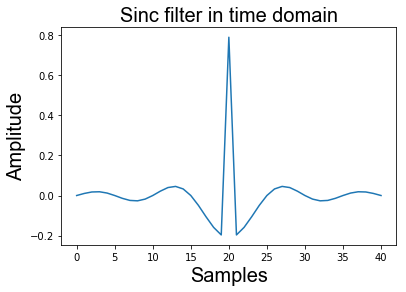

In [29]:
plt.plot(n, sinc_func)
plt.xlabel('Samples', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.title('Sinc filter in time domain', **fig_font)
plt.show()

## Take a look at the filter in the frequency domain - should look our lp filters but in reverse

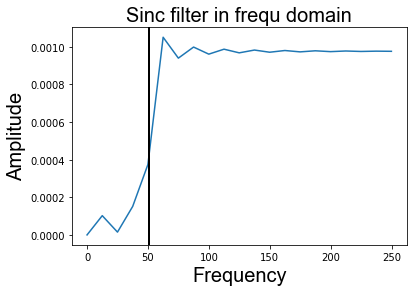

In [30]:
# take the fft, convert to amplitude, then normalize
sinc_fft = (np.abs(np.fft.rfft(sinc_func)) / len(sig) ) * 2

# figure out the frequency resolution of the data
# recall that our 'dt' here is calculated based on the signal 
# that we set up at the begining of the tutorial with a 
# sr = 512, so fc*512 should be around our filter fall-off
freq = np.fft.rfftfreq(sinc_func.size, dt)   

plt.plot(freq, sinc_fft)
plt.axvline(fc*sr, color = 'k', linewidth = 2)
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.title('Sinc filter in frequ domain', **fig_font)
plt.show()

## Apply the filter to the data - should pass all the high freq stuff and attenuate the low-freq stuff...

In [39]:
%%writefile apply_filter
def apply_filter(input_sig, input_filter):
    """Apply a filter to an input timeseries (using freq domain multiplication)

    Args:
        input_sig (float): timeseries to be filtered
        input_filter (float): filter to apply to ißnput_sig

    Returns:
        filt_sig (float array): filtered signal 

    """
    # fft our signal
    fft_sig = np.fft.rfft(input_sig)

    # need to zero pad to make the filter the same length as the signal
    X = len(input_sig)
    Y = len(input_filter)

    # zero pad in the time domain
    if Y<X:
        input_filter = np.hstack((input_filter, np.zeros(X-Y)))

    # fft the filter
    fft_filt = np.fft.rfft(input_filter)

    # multiply in freq domain, then ifft to go back into the time domain
    return np.fft.irfft(fft_sig*fft_filt)

Writing apply_filter


## Call our function to HP filter the data

In [37]:
filt_sig=apply_filter(input_sig=sig, input_filter=sinc_func)

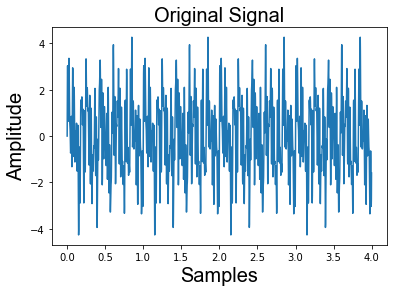

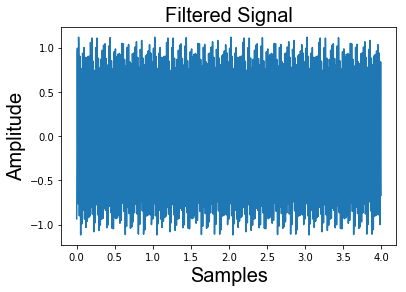

In [38]:
# Plot the regular signal
plt.plot(t, sig)
plt.xlabel('Samples', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.title('Original Signal', **fig_font)
plt.show()

# plot the filtered signal
plt.plot(t, filt_sig)
plt.xlabel('Samples', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.title('Filtered Signal', **fig_font)
plt.show()

## Then fft the original signal and the filtered signal to compare in the frequency domain
* Can go back and adjust 'b' to change the roll-off 

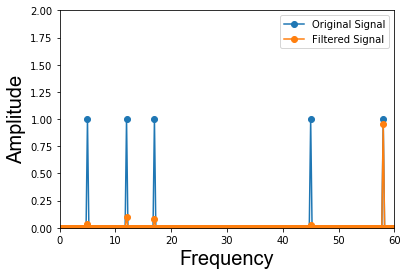

In [33]:
# fft our signal
fft_sig = (np.abs(np.fft.rfft(sig)) / len(sig) ) * 2
freq = np.fft.rfftfreq(sig.size, dt)   

# fft our filtered signal
fft_filt_sig = (np.abs(np.fft.rfft(filt_sig)) / len(filt_sig) ) * 2

# plot
plt.plot(freq, fft_sig, marker='o')
plt.plot(freq, fft_filt_sig, marker='o')
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xlim([0, 60])
plt.ylim([0, 2])
plt.legend(['Original Signal', 'Filtered Signal'])
plt.show()

## Now go back and see what happens if we don't apply any windowing function...check out the amplitude of the low frequencies, even though this is hp filter.

In [ ]:
fc=0.1
b=0.1
win = 'none'
type_filt = 'hp'

# make our function call to generate a hp filter
n, sinc_func = define_sinc_filter(fc=fc, b=b, window=win, type_filt=type_filt)